### Building Machine Learning Models

During EDA, we found that there was a correlation between several variables in the New York City Airbnb dataset. One such example was correlation between price and neighbourhood group. 

In this notebook, we will build some predictive models using machine learning techniques, such as linear regression, data splitting, ridge regression and random forest regressor.

#### Load Modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

from xgboost import XGBRegressor


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
Combined_data = pd.read_csv('C:/Users/cathe/projects/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
Combined_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
print('Number of features: {}'.format(Combined_data.shape[1]))
print('Number of examples: {}'.format(Combined_data.shape[0]))

Number of features: 16
Number of examples: 48895


In [4]:
#for c in df.columns:
#    print(c, dtype(df_train[c]))
Combined_data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [5]:
Combined_data['last_review'] = pd.to_datetime(Combined_data['last_review'],infer_datetime_format=True) 

## Preprocessing and EDA

### Missing Data

Many machine learning algorithms do badly when acting upon inputs with missing data. To help deal with this, we start by taking count of the missing values in each column.

In [6]:
total = Combined_data.isnull().sum().sort_values(ascending=False)
percent = (Combined_data.isnull().sum())/Combined_data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
reviews_per_month,10052,0.205583
last_review,10052,0.205583
host_name,21,0.000429
name,16,0.000327
availability_365,0,0.000000
calculated_host_listings_count,0,0.000000
number_of_reviews,0,0.000000
minimum_nights,0,0.000000
price,0,0.000000
room_type,0,0.000000


In [7]:
Combined_data.drop(['host_name','name'], axis=1, inplace=True)

In [8]:
Combined_data[Combined_data['number_of_reviews']== 0.0].shape

(10052, 14)

The NaN values in the last_review and reviews_per_month columns occur for examples where no reviews were given in the first place. For reviews_per_month, we will fill thoses values with 0s.

In [9]:
Combined_data['reviews_per_month'] = Combined_data['reviews_per_month'].fillna(0)

In [10]:
earliest = min(Combined_data['last_review'])
Combined_data['last_review'] = Combined_data['last_review'].fillna(earliest)
Combined_data['last_review'] = Combined_data['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [11]:
total = Combined_data.isnull().sum().sort_values(ascending=False)
percent = (Combined_data.isnull().sum())/Combined_data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
availability_365,0,0.0
calculated_host_listings_count,0,0.0
reviews_per_month,0,0.0
last_review,0,0.0
number_of_reviews,0,0.0
minimum_nights,0,0.0
price,0,0.0
room_type,0,0.0
longitude,0,0.0
latitude,0,0.0


### Choosing a prediction target (Smart Pricing Regressor)
One type of machine learning model at AirBnb is Smart Pricing. After a customer has entered the details of their rental, AirBnb then suggests them an appropriate price. The goal of this notebook is to build and train a Smart Pricing model for this dataset.

#### Price Distribution
The target has a highly skewed distribution and can cause problems for machine learning algorithms such as linear regression. A log transformation and removal of outliers makes the distribution look much closer to normal.

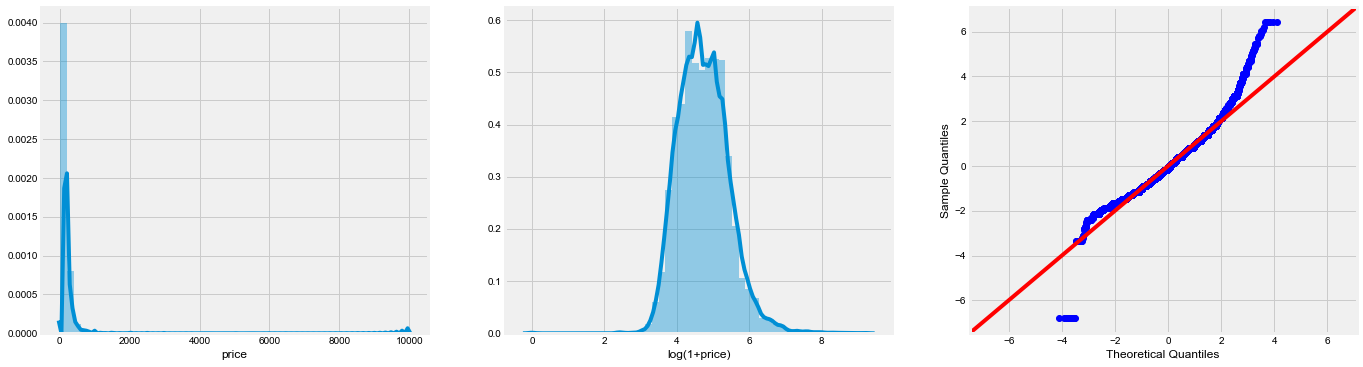

In [12]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(Combined_data['price'], ax=axes[0])
sns.distplot(np.log1p(Combined_data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(Combined_data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [13]:
Combined_data = Combined_data[np.log1p(Combined_data['price']) < 8]
Combined_data = Combined_data[np.log1p(Combined_data['price']) > 3]

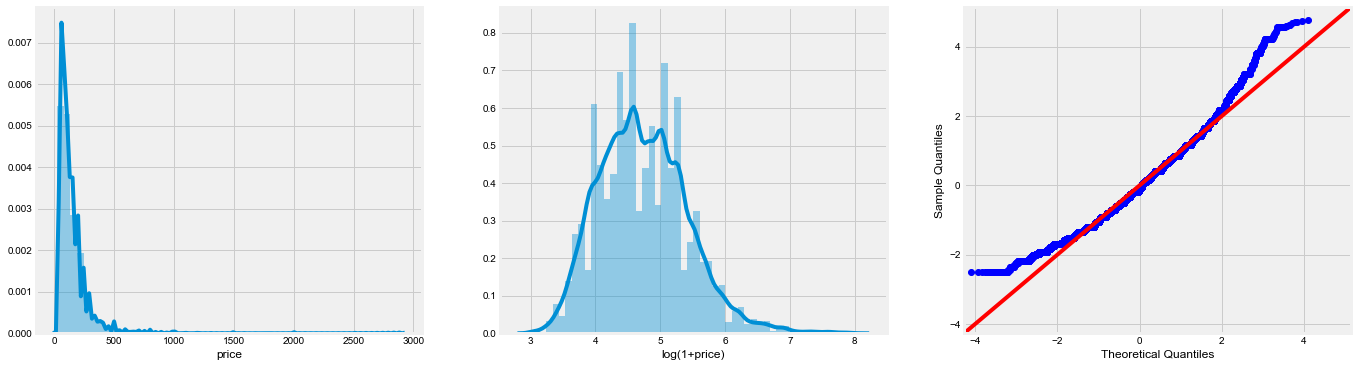

In [14]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(Combined_data['price'], ax=axes[0])
sns.distplot(np.log1p(Combined_data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(Combined_data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [15]:
Combined_data['price'] = np.log1p(Combined_data['price'])

### Predictor distributions

#### A list of predictors

In [16]:
print(Combined_data.columns)

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


#### Host_id

In [17]:
print('In this dataset, there are {} unique hosts renting out a total number of {} properties.'
.format(len(Combined_data['host_id'].unique()), Combined_data.shape[0]))

In this dataset, there are 37384 unique hosts renting out a total number of 48784 properties.


Since the number of hosts is close to the total number of examples, we are not going to use hostname in our regression analysis due to it causing the number of parameters to blow up. In reality, when there is more data and possibly some feature data on hosts. Past history of a host and property can be expected to be a high predictor of price. 

In [18]:
Combined_data = Combined_data.drop(['host_id', 'id'], axis=1)

#### Neighbourhood group
Staten Island and the Bronx are highly underrepresented in this dataset. For Staten Island, it is due to the population of the island being small. But this cannot be the case for the Bronx(around 1.4 million) which has a population comparable to Manhattan(around 1.6 million), Brooklyn (around 2.5 million), or Queens (around 2.4 million).

This makes sense since Queens, Bronx, and to a fair extent Brooklyn are residential neighborhoods. Whereas, Manhattan is a business center and tourist destination.

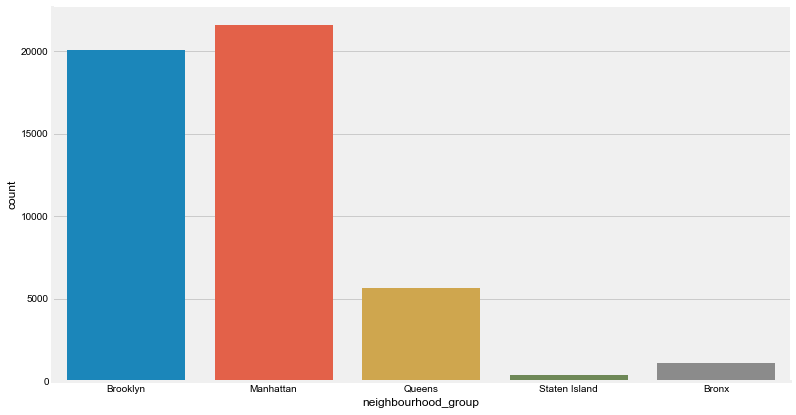

In [19]:
sns.catplot(x='neighbourhood_group', kind='count' ,data=Combined_data)
fig = plt.gcf()
fig.set_size_inches(12, 6)

#### Longitude and Latitude
Longitude and latitude are somewhat correlated with each other since the locations of properties tend to come from clusters.

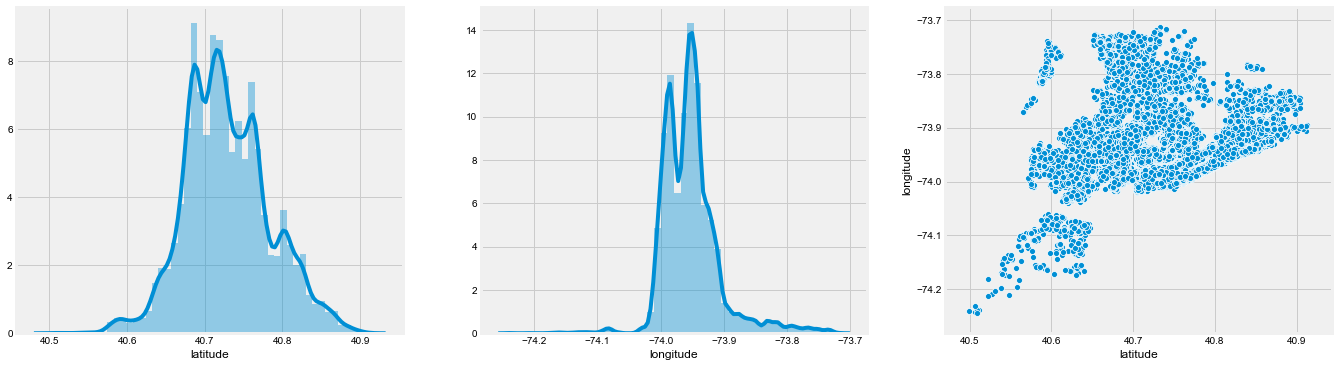

In [20]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(Combined_data['latitude'], ax=axes[0])
sns.distplot(Combined_data['longitude'], ax=axes[1])
sns.scatterplot(x= Combined_data['latitude'], y=Combined_data['longitude'])

#### Room type
As far as room types go, this dataset is balanced away from 'Shared room' properties. The proportions for private room and entire home/apt rentals are close, with entire home/apt dominating private room by <10%.

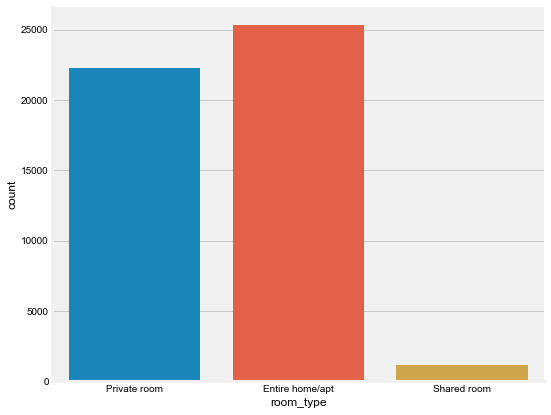

In [21]:
sns.catplot(x='room_type', kind='count' ,data=Combined_data)
fig = plt.gcf()
fig.set_size_inches(8, 6)

#### Minimum Nights

Text(0, 0.5, 'count')

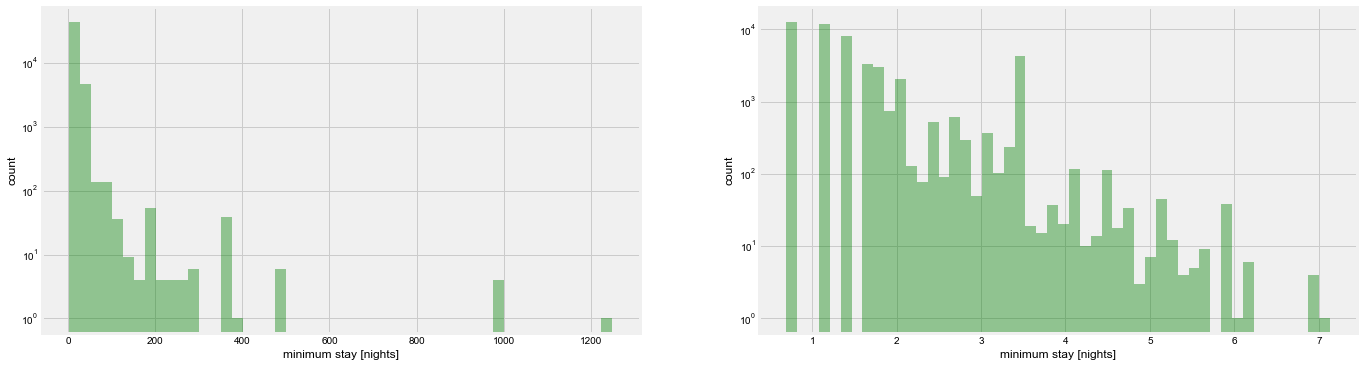

In [22]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(Combined_data['minimum_nights'], rug=False, kde=False, color="green", ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(Combined_data['minimum_nights']), rug=False, kde=False, color="green", ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count')

In [23]:
Combined_data['minimum_nights'] = np.log1p(Combined_data['minimum_nights'])

#### Reviews per Month

Text(0.5, 0, 'ln(reviews_per_month)')

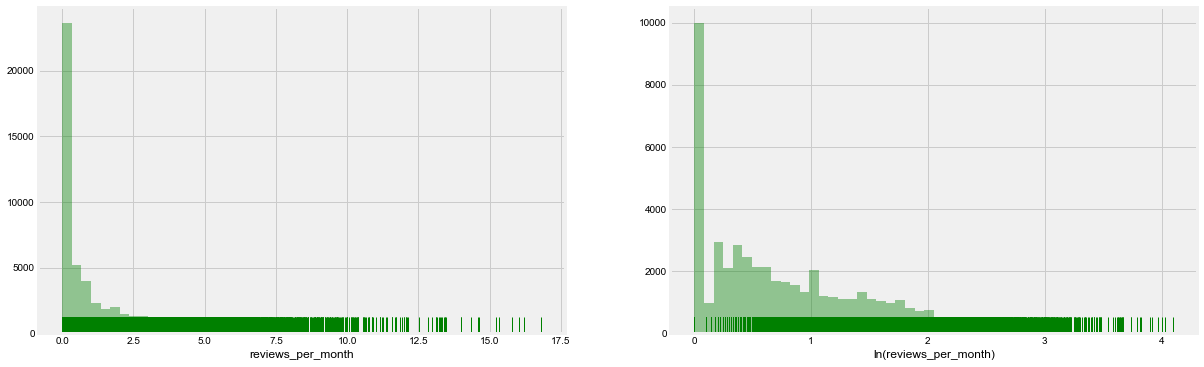

In [24]:
fig, axes = plt.subplots(1,2,figsize=(18.5, 6))
sns.distplot(Combined_data[Combined_data['reviews_per_month'] < 17.5]['reviews_per_month'], rug=True, kde=False, color="green", ax=axes[0])
sns.distplot(np.sqrt(Combined_data[Combined_data['reviews_per_month'] < 17.5]['reviews_per_month']), rug=True, kde=False, color="green", ax=axes[1])
axes[1].set_xlabel('ln(reviews_per_month)')

Distribution of the number of reviews per month is highly skewed however which way we cut it. This is due to there being a large weight on small numbers: there are a lot of properties which only get a few reviews and a rather fat tail of properties which get a lot of reviews.

One possible explanation would be that properties available a larger fraction of the year get more reviews. However, a scatter plot of reviews_per_month and availability_365 variables shows no evidence of a relationship so that explanation would appear to not be valid.

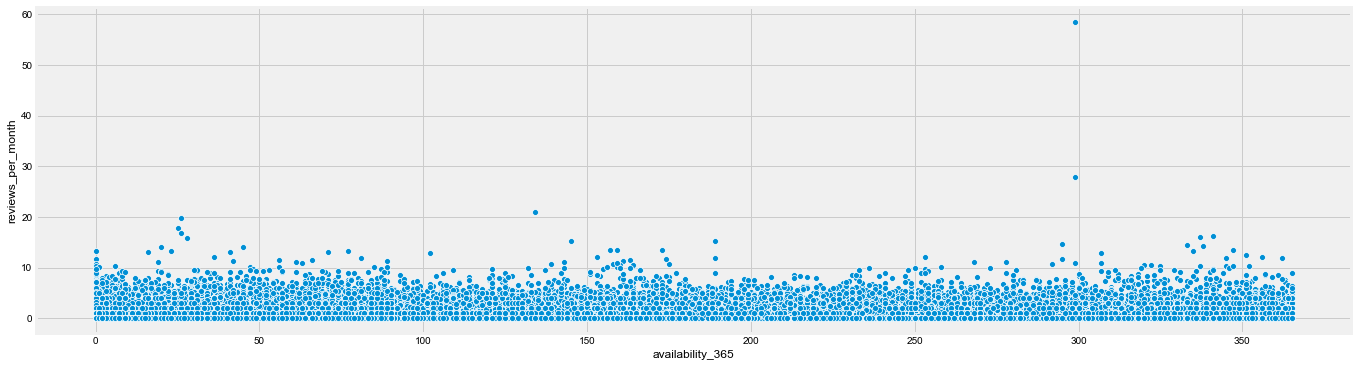

In [25]:
fig, axes = plt.subplots(1,1, figsize=(21,6))
sns.scatterplot(x= Combined_data['availability_365'], y=Combined_data['reviews_per_month'])

In [26]:
Combined_data['reviews_per_month'] = Combined_data[Combined_data['reviews_per_month'] < 17.5]['reviews_per_month']

#### Availability_365 
This distribution is highly skewed towards the low and high end. The dataset contains a huge number of properties that are available only for a couple of days each year, and a decent number that are available for > 300 days.

(0, 365)

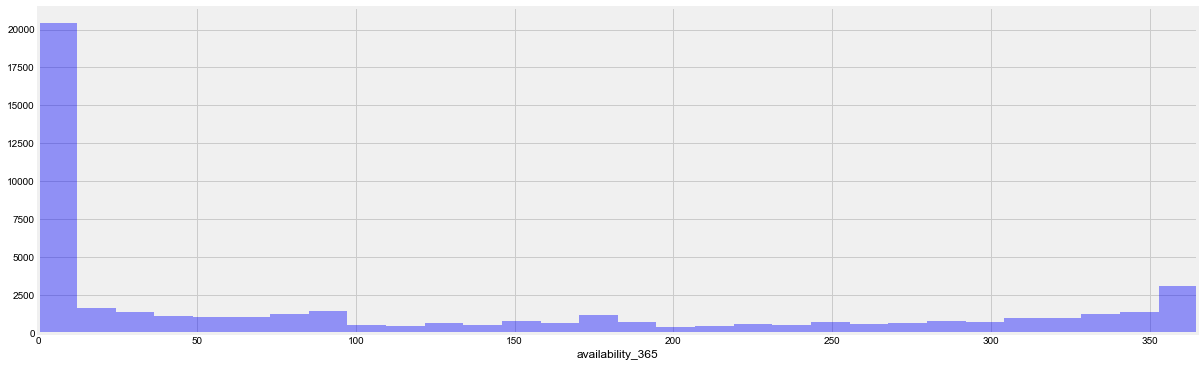

In [27]:
fig, axes = plt.subplots(1,1,figsize=(18.5, 6))
sns.distplot(Combined_data['availability_365'], rug=False, kde=False, color="blue", ax=axes)
axes.set_xlabel('availability_365')
axes.set_xlim(0, 365)

#### Feature engineering

In [28]:
Combined_data['all_year_avail'] = Combined_data['availability_365']>353
Combined_data['low_avail'] = Combined_data['availability_365']< 12
Combined_data['no_reviews'] = Combined_data['reviews_per_month']==0

### Bivariate correlations
#### 1.5.0 Pearson correlation matrix

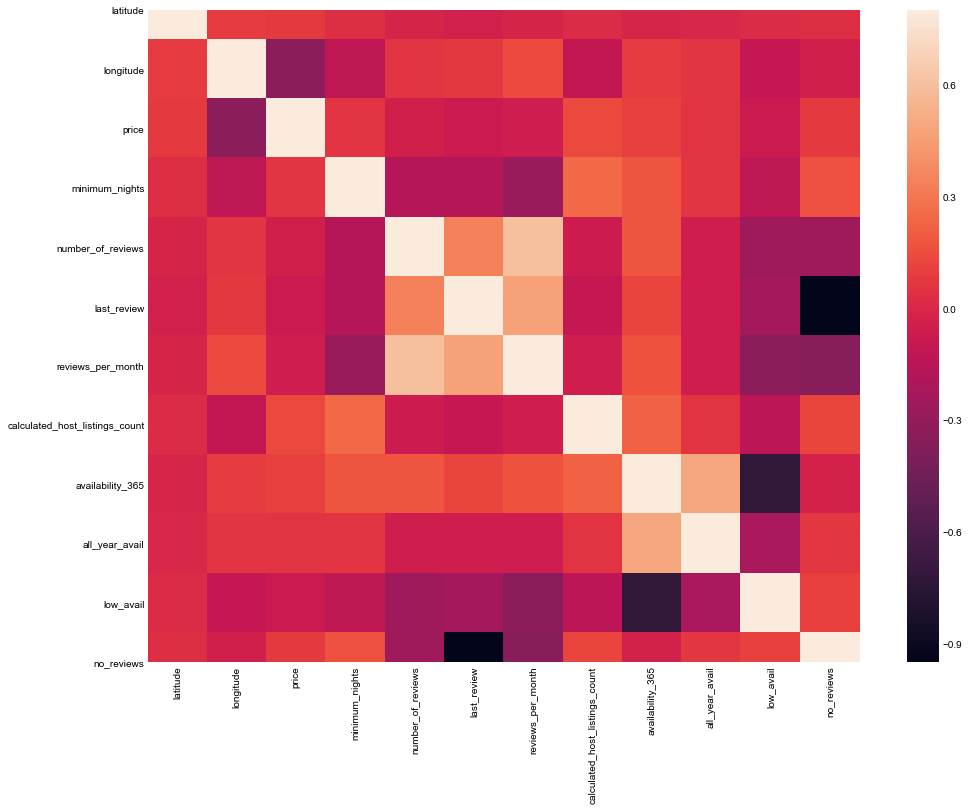

In [29]:
corrmatrix = Combined_data.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)

There doesn't appear to be an obvious strong correlation between these variables. However, the number of reviews per month is fairly (at 40%) correlated with the total number of reviews and the total number of reviews is correlated (at 30%) with the availability of the property. Both correlations make sense. 

It is also interesting to note that longitude anticorrelated (at 20%) with the price. This also makes sense since a property in either the Bronx or Queens is cheaper than Manhattan or Brooklyn.

### Encoding categorical features

In [30]:
categorical_features = Combined_data.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

Categorical features: (48784, 3)


In [31]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [32]:
Combined_data['reviews_per_month'] = Combined_data['reviews_per_month'].fillna(0)

### Save transformed dataframe for future use

In [33]:
numerical_features =  Combined_data.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
print('Numerical features: {}'.format(numerical_features.shape))

Numerical features: (48784, 11)


In [34]:
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)
#print('Dimensions of the design matrix: {}'.format(X.shape))
#print('Dimension of the target vector: {}'.format(y.shape))

In [35]:
Processed_data = pd.concat([X_df, y], axis = 1)
Processed_data.to_csv('NYC_Airbnb_Processed.csv')

### Train-test split
We will split the data into a test set and a training set. We'll hold out test set until the very end and use the error on those data as an unbiased estimate of how these models did.

A further split may be done later on the training set into training set proper and a validation set or I might cross-validate.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (39027, 240)
Dimensions of the training target vector: (39027,)
Dimensions of the test feature matrix: (9757, 240)
Dimensions of the test target vector: (9757,)


### Rescaling the design matrix
We will now scale the design matrix with sklearn's RobustScaler() so that each predictor has zero mean and unit variance. This helps the convergence of machine learning algorithms such as linear regression.

In [38]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Models
### Cross-validation routine
Scoring models based on K-fold cross-validation with 5 folds.

In [39]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

### Scoring basic models (no parameter tuning)

In [40]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 184955901548910.78125 +/- 326694589664454.125000
Ridge: 0.19438 +/- 0.006210
Lasso: 0.45210 +/- 0.006634
ElasticNet: 0.45141 +/- 0.006620
RandomForestRegressor: 0.19240 +/- 0.005437
XGBRegressor: 0.18415 +/- 0.006391
HuberRegressor: 0.20340 +/- 0.008581


### Ridge Regression
#### Hyperparameter optimization
We find the best value of the L2 penalty hyperparameter with a telescopic search based on cross-validation scores. We then train the Ridge model on the entire training set and test to see how it performs on the held-out set.

In [41]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [42]:
alphas2 = [0.5*i for i in range(4,12)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

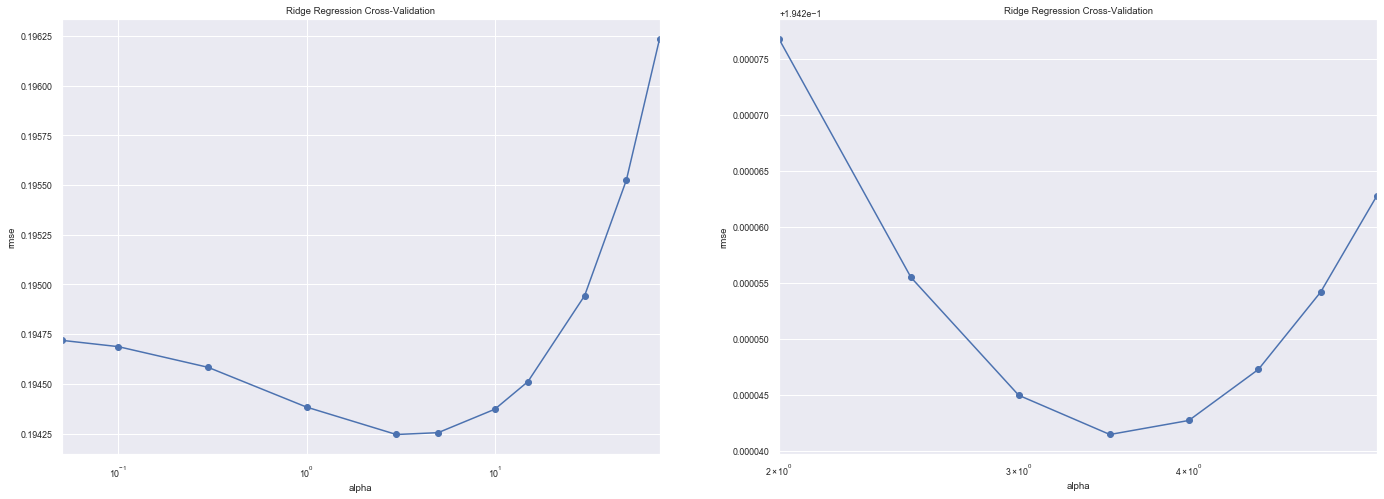

In [43]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots(1,2,figsize=(21, 8))
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[0]) 
axes[0].set_xlabel("alpha") 
axes[0].set_ylabel("rmse")
axes[0].set_xscale('log')

cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[1]) 
axes[1].set_xlabel("alpha") 
axes[1].set_ylabel("rmse")
axes[1].set_xscale('log')

#RR_best = Ridge(alpha = np.argmin(cv_ridge)) RR_best.fit(X_train, y_train) predicted_prices = RR_best.predict(test_data)

In [44]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas1,
        y= cv_ridge1,
        line = dict(color='royalBlue', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            )
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Telescopic Search: Coarse level', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()

In [45]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas2,
        y= cv_ridge2,
        line = dict(color='crimson', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            ),
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Telescopic Search: Fine level', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()

#### Best Ridge Regression Model

In [46]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)]
RR_CV_best = -rmse_cv(Ridge(alpha = best_alpha))
RR = Ridge(alpha = best_alpha) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': RR_CV_best.mean(), 
            'CV std': RR_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR)],
            'test error': [mean_squared_error(y_test_RR, y_test_RR)],
            'training_r2_score': [r2_score(y_train, y_train_RR)],
            'test_r2_score': [r2_score(y_test, y_test_RR)]})
ridge_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression,0.194241,0.006121,0.191407,0.0,0.583508,0.573302


### LASSO Regressor

#### Hyperparameter optimization
The training error for LASSO is slightly higher than for Ridge (~0.198 vs ~0.197). However, the difference is quite small so that LASSO is still useful for a variable selector.

In [47]:
alphas = [0.001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 1]
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]

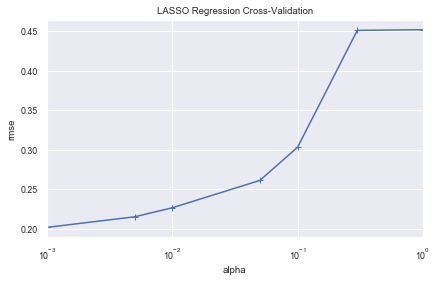

In [48]:
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "LASSO Regression Cross-Validation", style='-+')
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.xscale('log')

In [49]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas,
        y= cv_lasso,
        line = dict(color='crimson', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            ),
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Lasso penalty optimization', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()

In [50]:
best_alpha = alphas[np.argmin(cv_lasso.values)]
lasso_CV_best = -rmse_cv(Lasso(alpha = best_alpha))
lasso = Lasso(alpha = best_alpha) 
lasso.fit(X_train, y_train) 
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)
lasso_results = pd.DataFrame({'algorithm':['LASSO Regression'],
            'CV error': lasso_CV_best.mean(), 
            'CV std': lasso_CV_best.std(),
            'training error': [mean_squared_error(y_train_lasso, y_train)],
            'test error': [mean_squared_error(y_test_lasso, y_test)],
            'training_r2_score': [r2_score(y_train, y_train_lasso)],
            'test_r2_score': [r2_score(y_test, y_test_lasso)]})
lasso_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,LASSO Regression,0.201713,0.006941,0.201108,0.200331,0.5624,0.561874


#### Variables Selected

In [51]:
features = list(categorical_features_one_hot.columns) + list(numerical_features.columns)
coef = pd.Series(lasso.coef_, index = features)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 45 variables and eliminated the other 195 variables


In [52]:
coef

neighbourhood_group_Bronx           -0.000380
neighbourhood_group_Brooklyn        -0.096340
neighbourhood_group_Manhattan       -0.125013
neighbourhood_group_Queens          -0.009122
neighbourhood_group_Staten Island   -0.026085
                                       ...   
calculated_host_listings_count       0.000000
availability_365                    -0.000000
all_year_avail                       0.754575
low_avail                            0.000000
no_reviews                          -0.365968
Length: 240, dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

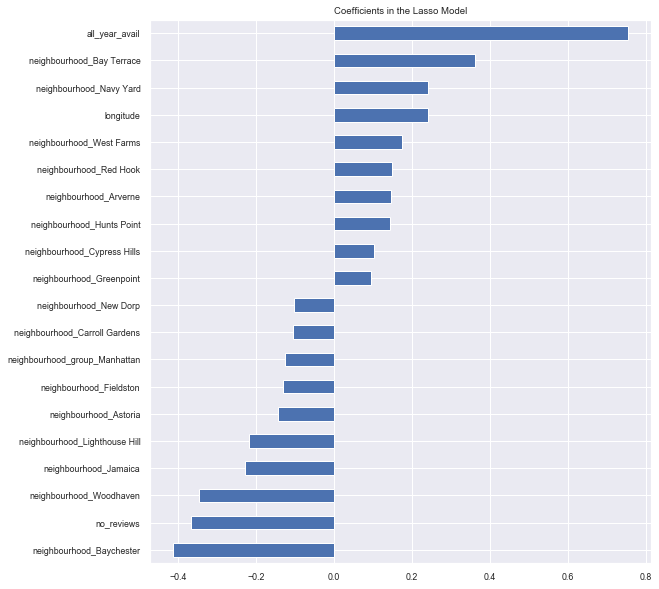

In [53]:
imp_coef = pd.concat([coef.sort_values().iloc[:10],
                     coef.sort_values().iloc[-10:]])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Huber Regression

In [54]:
alphas = [0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
#cv_huber = [-rmse_cv(HuberRegressor(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]
cv_huber = [0.20051906841425277, 0.20044833042114646, 0.20048899799050565, 0.200533996471012, 0.20051788009059482, 0.2005294886778608, 0.20052011204607623, 0.2004070661477452]

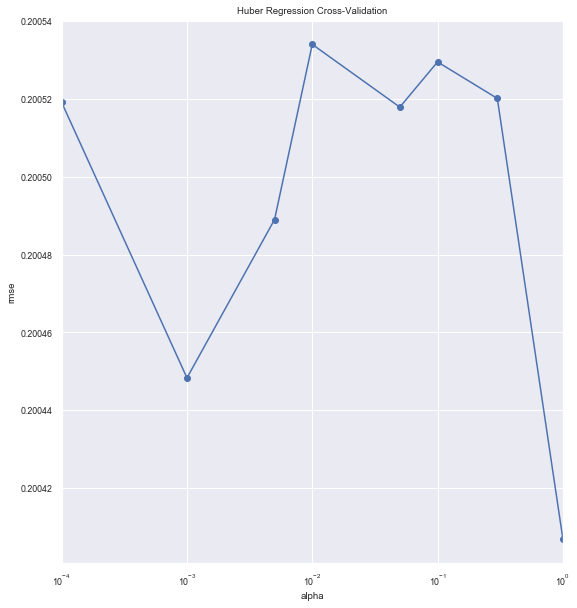

In [55]:
cv_huber = pd.Series(cv_huber, index = alphas) 
cv_huber.plot(title = "Huber Regression Cross-Validation", style='-o') 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
plt.xscale('log')

In [56]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas,
        y= cv_huber,
        line = dict(color='crimson', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            ),
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Lasso penalty optimization', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()

In [57]:
best_alpha = alphas[np.argmin(cv_huber.values)]
huber_CV_best = -rmse_cv(HuberRegressor(alpha=best_alpha))
huber = HuberRegressor(alpha=best_alpha)
huber.fit(X_train, y_train) 
y_train_huber = huber.predict(X_train)
y_test_huber = huber.predict(X_test)
huber_results = pd.DataFrame({'algorithm':['Huber Regression'],
            'CV error': huber_CV_best.mean(), 
            'CV std': huber_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_huber)],
            'test error': [mean_squared_error(y_test, y_test_huber)],
            'training_r2_score': [r2_score(y_train, y_train_huber)],
            'test_r2_score': [r2_score(y_test, y_test_huber)]})
huber_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Huber Regression,0.204321,0.008261,0.208299,0.208069,0.546753,0.54495


### Ridge with variables selected by LASSO
Something that should be attempted is rerunning algorithms on the feature subset selected by LASSO. With this dataset, there does not seem to bring improvement. In fact, the values of the loss go slightly up for all variables or there is no change.

In [58]:
lasso_coef = coef[coef!=0]
Xlv = X_df[list(lasso_coef.index)]
#X_lasso_vars.shape
Xlv_train, Xlv_test, y_train, y_test = train_test_split(Xlv, y, test_size=0.2, random_state=42)
print('Dimensions of the training feature matrix for lasso variable selection: {}'.format(Xlv_train.shape))
print('Dimensions of the test feature matrix for lasso variable selection: {}'.format(Xlv_test.shape))

Dimensions of the training feature matrix for lasso variable selection: (39027, 45)
Dimensions of the test feature matrix for lasso variable selection: (9757, 45)


In [59]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_lv_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.36950 +/- 0.005441
Ridge: 0.36949 +/- 0.005502
Lasso: 0.45962 +/- 0.006865
ElasticNet: 0.45962 +/- 0.006865
RandomForestRegressor: 0.47400 +/- 0.003839
XGBRegressor: 0.18415 +/- 0.006391
HuberRegressor: 0.39189 +/- 0.007851


#### Ridge Regression Hyperparameter Optimization 

In [60]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [61]:
alphas2 = [1.4+0.05*i for i in range(1,12)]
cv_ridge2 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

Text(0, 0.5, 'rmse')

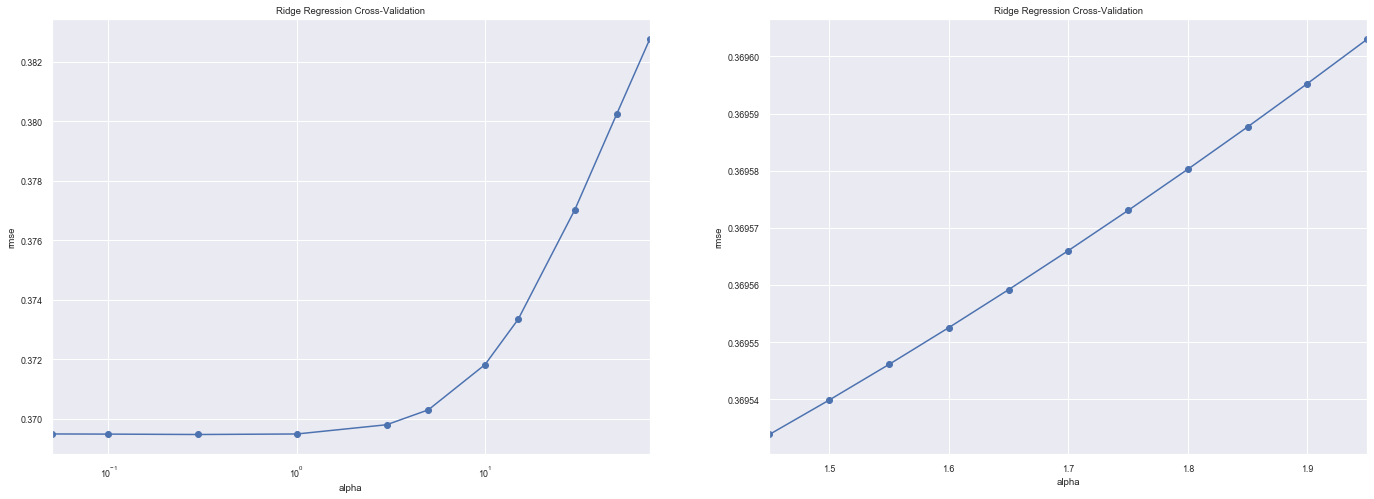

In [62]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots(1,2,figsize=(21, 8))
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[0]) 
axes[0].set_xlabel("alpha") 
axes[0].set_ylabel("rmse")
axes[0].set_xscale('log')

cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[1]) 
axes[1].set_xlabel("alpha") 
axes[1].set_ylabel("rmse")
#axes[1].set_xscale('log')

#RR_best = Ridge(alpha = np.argmin(cv_ridge)) RR_best.fit(X_train, y_train) predicted_prices = RR_best.predict(test_data)

In [63]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)]
RR_lassoVars_CV_best = -rmse_lv_cv(Ridge(alpha = best_alpha))
RR_lassoVars = Ridge(alpha = best_alpha) 
RR_lassoVars.fit(Xlv_train, y_train) 
y_train_RR_lassoVars = RR_lassoVars.predict(Xlv_train)
y_test_RR_lassoVars = RR_lassoVars.predict(Xlv_test)
ridge_lassoVars_results = pd.DataFrame({'algorithm':['Ridge Regression with LASSO variable selection'],
            'CV error': RR_lassoVars_CV_best.mean(), 
            'CV std': RR_lassoVars_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR_lassoVars)],
            'test error': [mean_squared_error(y_test, y_test_RR_lassoVars)],
            'training_r2_score': [r2_score(y_train, y_train_RR_lassoVars)],
            'test_r2_score': [r2_score(y_test, y_test_RR_lassoVars)]})

### Random Forest Regressor

In [64]:
rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state=42))
rfr_baseline = RandomForestRegressor(random_state=42)
rfr_baseline.fit(X_train, y_train) 
y_train_rfr = rfr_baseline.predict(X_train)
y_test_rfr = rfr_baseline.predict(X_test)
rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
            'CV error': rfr_CV_baseline.mean(), 
            'CV std': rfr_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_rfr, y_train)],
            'test error': [mean_squared_error(y_test_rfr, y_test)]})

In [65]:
rfr_baseline_results

,algorithm,CV error,CV std,training error,test error
0,Random Forest Regressor [baseline],0.193192,0.004573,0.033727,0.200167
